In [1]:
using Printf
using Plots; gr()

Plots.GRBackend()

In [2]:
"Run a Cmd object, returning the stdout & stderr contents plus the exit code"
function execute(cmd::Cmd)
  out = Pipe()
  err = Pipe()

  process = run(pipeline(ignorestatus(cmd), stdout=out, stderr=err))
  close(out.in)
  close(err.in)

  (
    stdout = String(read(out)), 
    stderr = String(read(err)),  
    code = process.exitcode
  )
end

execute

In [3]:
function pingstats(machine::String, num::Int, verbose::String)
    out = Vector{Float64}(undef, num)
    
    for i in 1:num
        cmd = is_windows() ? `ping $machine -n 1` : `ping $machine -c 1 -s 64 -i 1`
        output, err, code = execute(`$cmd`)
        
        if occursin("time=", output)
            found = match(r"time=(\d+(?:\.\d+)?) ms", output)
            if found !== nothing
                time_ms = parse(Float64, found.captures[1])
                out[i] = time_ms
                if verbose != ""
                    @printf("Ping %d\n", i)
                end
            end
        end
    end
    
    return out
end

pingstats (generic function with 1 method)

In [4]:
function is_windows()
    return Sys.iswindows()
end


is_windows (generic function with 1 method)

In [5]:
# Example usage:
# stats = pingstats("isl.stanford.edu", 100, "v")
# or
# stats = pingstats("www.google.com", 100, "v")
stats = pingstats("www.thestar.ca", 1000, "");

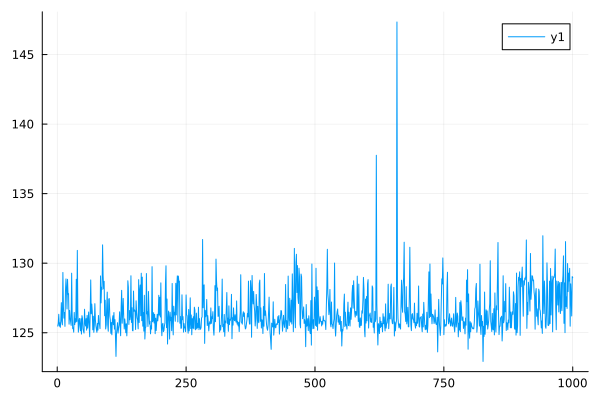

In [41]:
plot(stats)

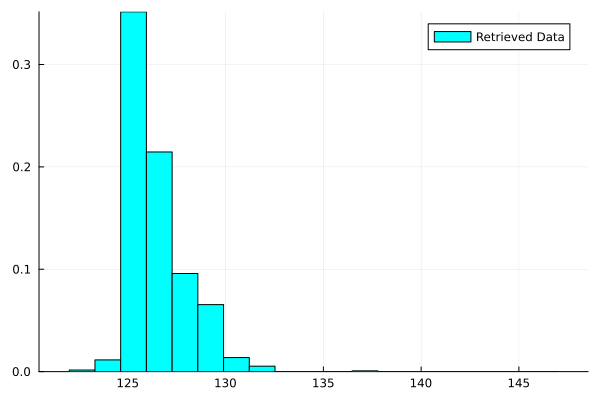

In [45]:
using StatsPlots
# Select the variable for which you want to plot the marginal density
variable_index = 1  # Index of the variable (1 for the first variable, 2 for the second)
selected_variable = stats[:, variable_index];
# Plot the marginal density using a histogram
b_range = range(trunc(Int, minimum(stats)), trunc(Int, maximum(stats)), length=20)
histogram(stats, label="Retrieved Data", bins=b_range, normalize=:pdf, color=:Cyan)

In [46]:
using Turing

In [47]:
@model function gdemo(xs) 
    # priors 
    σ² ~ InverseGamma(2 , 3)
    μ ~ Normal(0 , σ²)
    R ~ Rayleigh(4)
    E₁ ~ Erlang(1)
    E₂ ~ Erlang(2)
    exp ~ Exponential()

    # likelihood
    for i in eachindex(xs)
        xs[i] ~ Normal(μ , σ²)
    end
end

gdemo (generic function with 2 methods)

In [48]:
# Construct a model with our data
model = gdemo(stats);

In [49]:
chain = sample(
    model, 
    NUTS(), 
    1000 # Number of samples
)

┌ Info: Found initial step size
└   ϵ = 0.0001953125
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (1000×18×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 1.82 seconds
Compute duration  = 1.82 seconds
parameters        = σ², μ, R, E₁, E₂, exp
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters       mean       std      mcse    ess_bulk   ess_tail      rhat   ⋯
      Symbol    Float64   Float64   Float64     Float64    Float64   Float64   ⋯

          σ²     4.3053    0.0954    0.0033    829.3750   569.5329    0.9991   ⋯
           μ   126.3782    0.1328    0.0042   1018.8806   803.8449    1.0017   ⋯
           R     4.8288    2.5711    0.1000    547.4835   342.5153    1.0058   ⋯
          E₁     1.0184    0.9989    0.0287   1122.9367   555.2235    1.0002   ⋯
          E₂     1.9366    1.3598    0.0490    565.81

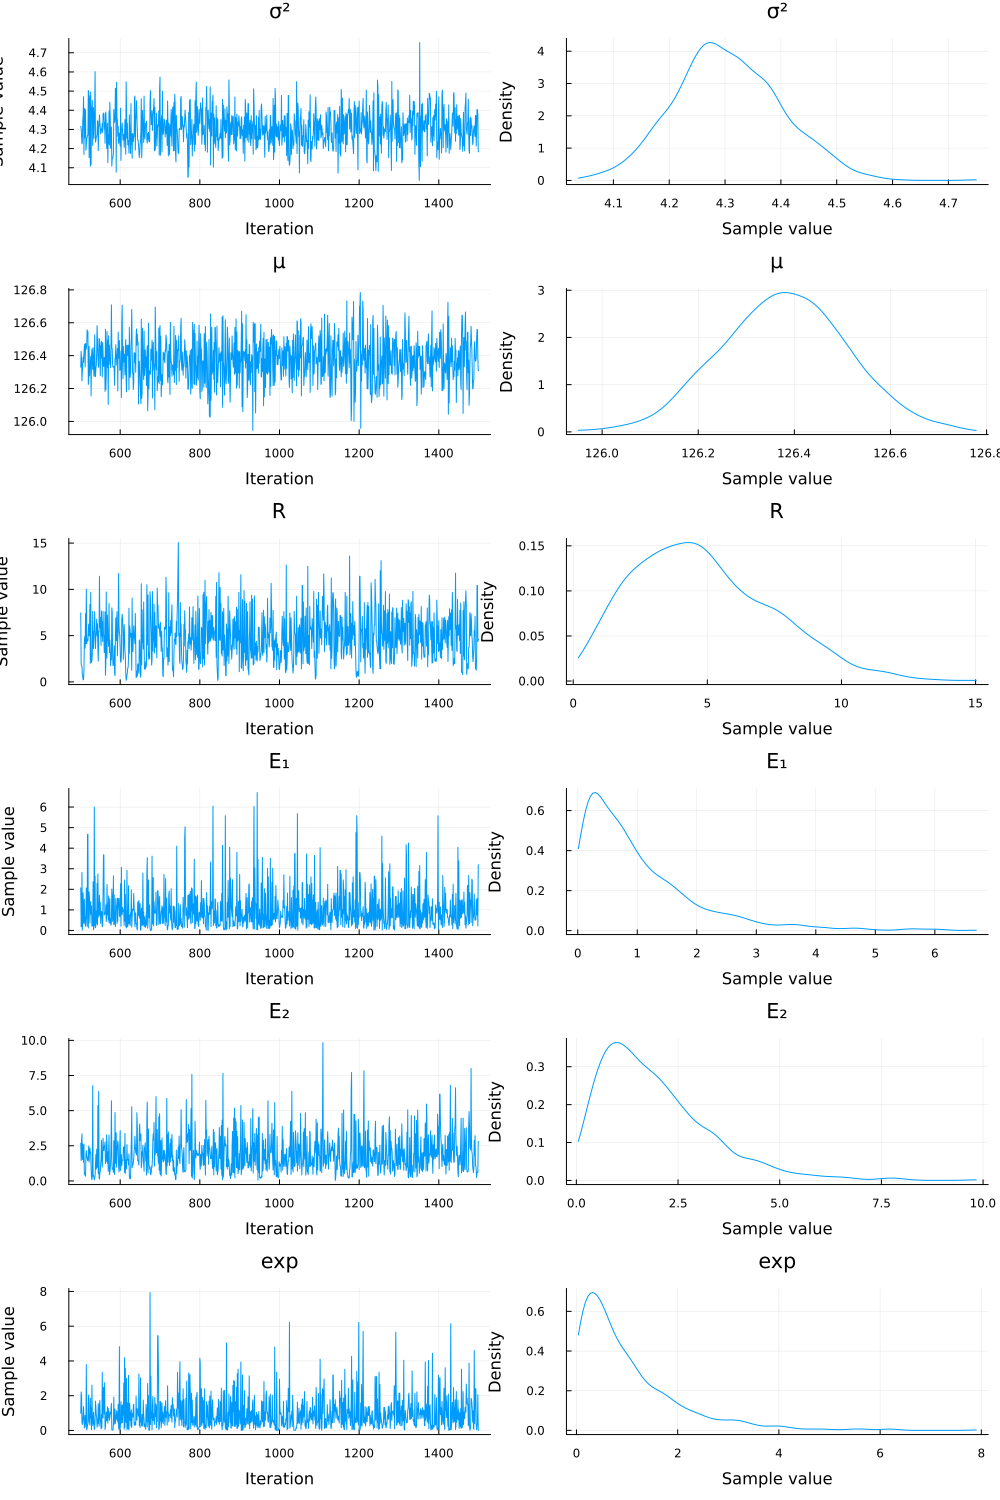

In [50]:
plot(chain)

In [51]:
using Optim

In [52]:
mle = Optim.optimize(model, MLE());
mle.values

6-element Named Vector{Float64}
A   │ 
────┼──────────
σ²  │   1.59375
μ   │   126.497
R   │    3.6697
E₁  │ 0.0328509
E₂  │   1.90785
exp │  0.193617

In [53]:
argmax = maximum(mle.values)

126.49659599999995

In [55]:
# Select the variable for which you want to plot the marginal density
variable_index = 1  # Index of the variable (1 for the first variable, 2 for the second)
selected_variable = stats[:, variable_index];
selected_variable1 = chain[:μ ][:, variable_index];

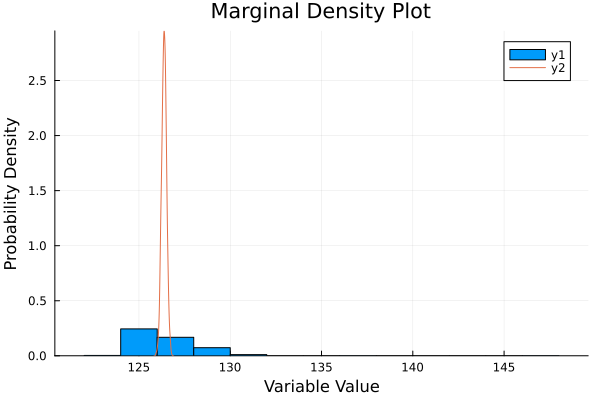

In [56]:
# Plot the marginal density using a histogram
histogram(selected_variable, bins=20, normalize=true, xlabel="Variable Value", ylabel="Probability Density", title="Marginal Density Plot")
# histogram!(chain[:R]; label="Posterior R")
density!(selected_variable1; bins=20, normalize=true)

# References

- [ ] [Collecting all output from shell commands](https://discourse.julialang.org/t/collecting-all-output-from-shell-commands/15592/2)
- [ ] [Review of the Mathematics of Logistic Regression via MLE](https://github.com/johnmyleswhite/julia_tutorials/blob/master/Statistics%20in%20Julia%20-%20Maximum%20Likelihood%20Estimation.ipynb)